# Independence Analysis

In this notebook, we analyze the mutual information and correlation between the EFPs with varying normalizations vs. $p_T$ and $m_J$.

In [1]:
# python library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# plot style commands
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi']= 100

from scipy.stats import spearmanr, gamma

%reload_ext autoreload
%autoreload 2

In [2]:
mutual_info_figures_path = '/Users/raymondwynne/Desktop/FORCE/figures/mutual_info/'

# Read Data

In [3]:
# read in the R&D dataset from the LHC Olympics challenge
filename = '/Users/raymondwynne/Desktop/FORCE/data/LHCO/LHCO_'

# all of the constituents in the leading two jets of the event
#events = np.concatenate([np.load(filename + 'jets_{}.npz'.format(k))['arr_0'] for k in range(11)])

# the dijet masses and jet pTs of each of the events in the dataset
dijetmasses_in = np.load(filename+'dijetmasses.npz')['arr_0']
jetpts_in = np.load(filename+'jetpts.npz')['arr_0']

mask = jetpts_in.min(axis=1) > 0

# the first thirteen energy flow polynomials for each jet, shape: (num_events, 2, num_efps)
efps_in = np.concatenate([np.load(filename+'efps_{}.npz'.format(k))['arr_0'] for k in range(11)])

# normalize the EFPs to dimensionless boost invariant ones
ns, ds =  np.asarray([1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 6]), np.asarray([0, 1, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3])
efpnorms_in = efps_in[:,:,0,np.newaxis]**(ns-2*ds) * efps_in[:,:,1,np.newaxis]**(ds)
efpnorms_energy_in = efps_in[:,:,0,np.newaxis]**(ns-2*ds)
efpnorms_angle_in = efps_in[:,:,1,np.newaxis]**(ds)
efps_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_in, a_min=0, a_max=1000), nan=1)
efps_energy_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_energy_in, a_min=0, a_max=1000), nan=1)
efps_angle_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_angle_in, a_min=0, a_max=1000), nan=1)


# labels as to whether the event was new physics or not. Used for validation only
labels_in = np.concatenate([np.load(filename+'labels{}.npz'.format(k))['arr_0'] for k in range(11)])

dijetmasses_in, jetpts_in, efps_in, efps_normed_in, labels_in = dijetmasses_in[mask], jetpts_in[mask], efps_in[mask], efps_normed_in[mask], labels_in[mask]

/var/folders/ms/4vjyd3l14sn5wrwm880cg3y40000gn/T/ipykernel_43662/2059314642.py:21: RuntimeWarning: invalid value encountered in divide
  efps_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_in, a_min=0, a_max=1000), nan=1)
/var/folders/ms/4vjyd3l14sn5wrwm880cg3y40000gn/T/ipykernel_43662/2059314642.py:23: RuntimeWarning: invalid value encountered in divide
  efps_angle_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_angle_in, a_min=0, a_max=1000), nan=1)


In [4]:
fs = 0.5

f = fs / (1 - fs)

background_subset = 100000
signal_subset = 100000

# keep all background events and the first "count" signal events
mask_background = np.zeros(len(labels_in), dtype=bool)
mask_signal = np.zeros(len(labels_in), dtype=bool)
mask_signal_train = np.zeros(len(labels_in), dtype=bool)
mask_background[random.sample(list(np.where(labels_in==0)[0]), background_subset)] = True
mask_signal[random.sample(list(np.where(labels_in==1)[0]), signal_subset)] = True
mask_signal_train[random.sample(list(np.where(labels_in==1)[0]), background_subset)] = True
        
# apply the filter and shuffle the data!
nev_background = np.count_nonzero(mask_background)
nev_signal = np.count_nonzero(mask_signal)
nev_signal_train = np.count_nonzero(mask_signal_train)
nev = nev_background + nev_signal

perm_background = np.random.permutation(nev_background)
perm_background_2 = np.random.permutation(nev_background)
perm_signal = np.random.permutation(nev_signal)
perm_signal_2 = np.random.permutation(nev_signal)

labels_background, dijetmasses_background = (labels_in[mask_background][perm_background], dijetmasses_in[mask_background][perm_background])
jetpts_background, jetpts_background_shuffle = (jetpts_in[mask_background][perm_background], jetpts_in[mask_background][perm_background_2])
efps_background, efps_normed_background = (efps_in[mask_background][perm_background], efps_normed_in[mask_background][perm_background])
efps_energy_normed_background, efps_angle_normed_background = efps_energy_normed_in[mask_background][perm_background], efps_angle_normed_in[mask_background][perm_background]
efps_background_shuffle, efps_normed_background_shuffle = (efps_in[mask_background], efps_normed_in[mask_background])
jetmasses_background = 1000 * np.sqrt(efps_background[:, :, 2]/2)

labels_signal, dijetmasses_signal = (labels_in[mask_signal][perm_signal], dijetmasses_in[mask_signal][perm_signal])
jetpts_signal, jetpts_signal_shuffle = (jetpts_in[mask_signal][perm_signal], jetpts_in[mask_signal][perm_signal_2])
efps_signal, efps_normed_signal = (efps_in[mask_signal][perm_signal], efps_normed_in[mask_signal][perm_signal])
efps_energy_normed_signal, efps_angle_normed_signal = efps_energy_normed_in[mask_signal][perm_signal], efps_angle_normed_in[mask_signal][perm_signal]
efps_signal_shuffle, efps_normed_signal_shuffle = (efps_in[mask_signal], efps_normed_in[mask_signal])
jetmasses_signal = 1000 * np.sqrt(efps_signal[:, :, 2]/2)

perm_full = np.random.permutation(nev_background + nev_signal)

labels = np.concatenate([labels_background, labels_signal])[perm_full]
efps_normed = np.concatenate([efps_normed_background, efps_normed_signal])[perm_full]
efps_energy_normed = np.concatenate([efps_energy_normed_background, efps_energy_normed_signal])[perm_full]
efps_angle_normed = np.concatenate([efps_angle_normed_background, efps_angle_normed_signal])[perm_full]
efps = np.concatenate([efps_background, efps_signal])[perm_full]
jetpts = np.concatenate([jetpts_background, jetpts_signal])[perm_full]
jetpts_shuffle = np.concatenate([jetpts_background_shuffle, jetpts_signal_shuffle])[perm_full]
dijetmasses = np.concatenate([dijetmasses_background, dijetmasses_signal])[perm_full]
jetmasses = np.concatenate([jetmasses_background, jetmasses_signal])

jetmasses_b = np.concatenate([jetmasses_background[:, 0], jetmasses_background[:, 1]])
jetmasses_s = np.concatenate([jetmasses_signal[:, 0], jetmasses_signal[:, 1]])

# Analyzing Independence

In [5]:
def mutual_info(pxy,px,py):# I'll give it a shape of (dx,dy), (dx,), (dy,)
	MI = 0.0
	dx = len(px)
	dy = len(py)
	if pxy.shape[0]!=dx or pxy.shape[1]!=dy:
		return "Wrong shapes"
	else:
		MI=np.sum(list(map(lambda indx: list(map(lambda indy: pxy[indx,indy]*(np.log(pxy[indx,indy])-np.log(px[indx])-np.log(py[indy])) if pxy[indx,indy]>0.0 else 0.0,range(dy))),range(dx))))
		return MI


def compute_mutual_information(data1, data2, bins1, bins2):
    pD, bb1, bb2 = np.histogram2d(data1, data2, bins=[bins1, bins2], density=True)
    pD_norm = np.array([[(pD[indx, indy] * (bb1[indx+1] - bb1[indx]) * (bb2[indy+1] - bb2[indy]))
                         for indy in range(len(bb2)-1)] for indx in range(len(bb1)-1)])
    
    pD_marg_s = np.sum(pD_norm, axis=1)
    pD_marg_s = pD_marg_s / np.sum(pD_marg_s)
    
    pD_marg_y = np.sum(pD_norm, axis=0)
    pD_marg_y = pD_marg_y / np.sum(pD_marg_y)
    
    pD_from_marg = np.array([[(pD_marg_s[indx] * pD_marg_y[indy])
                              for indy in range(len(bb2)-1)] for indx in range(len(bb1)-1)])
    
    mutual_information = max([mutual_info(pD_norm, pD_marg_s, pD_marg_y), 0.0])
	
    asymptotic_distr = gamma(a=0.5*(len(bb1)-2)*(len(bb2)-2),scale=1.0/(len(data1)))
    p = asymptotic_distr.sf(mutual_information)

    return mutual_information, p

In [6]:
def calculate_metrics(X, Y, type):

    X_s_concat, X_b_concat = X[0], X[1]
    Y_s_concat, Y_b_concat = Y[0], Y[1]

    metrics = pd.DataFrame()

    for i in range(0, 9):
        X_b, Y_b = np.concatenate([X_b_concat[:, 0, i], X_b_concat[:, 1, i]]), np.concatenate([Y_b_concat[:, 0], Y_b_concat[:, 1]])
        X_s, Y_s = np.concatenate([X_s_concat[:, 0, i], X_s_concat[:, 1, i]]), np.concatenate([Y_s_concat[:, 0], Y_s_concat[:, 1]])

        spearman_signal = np.abs(spearmanr(X_s, Y_s)[0])
        spearman_background = np.abs(spearmanr(X_b, Y_b)[0])

        mi_signal, mi_p_signal =  compute_mutual_information(X_s, Y_s, 20, 20)
        mi_background, mi_p_background = compute_mutual_information(X_b, Y_b, 20, 20)

        mi_signal = np.abs(mi_signal)
        mi_background = np.abs(mi_background)

        mi_signal_result = pd.DataFrame(data=[[i, mi_signal, mi_p_signal, spearman_signal, 's', type]], columns=['index', 'mi', 'mi-p', 'spearman', 'sb', 'type'])
        mi_background_result = pd.DataFrame(data=[[i, mi_background, mi_p_background, spearman_background, 'b', type]], columns=['index', 'mi', 'mi-p', 'spearman', 'sb', 'type'])

        metrics = pd.concat([metrics, mi_signal_result])
        metrics = pd.concat([metrics, mi_background_result])
    
    return metrics

In [7]:
normalization_results_pt = pd.DataFrame()

normalization_results_pt = pd.concat([normalization_results_pt, calculate_metrics([efps_normed_signal, efps_normed_background], [jetpts_signal_shuffle, jetpts_background_shuffle], 'normed_shuffle')])
normalization_results_pt = pd.concat([normalization_results_pt, calculate_metrics([efps_normed_signal, efps_normed_background], [jetpts_signal, jetpts_background], 'Normalized')])
normalization_results_pt = pd.concat([normalization_results_pt,calculate_metrics([efps_energy_normed_signal, efps_energy_normed_background], [jetpts_signal, jetpts_background], 'Energy Normalized')])
normalization_results_pt = pd.concat([normalization_results_pt,calculate_metrics([efps_angle_normed_signal, efps_angle_normed_background], [jetpts_signal, jetpts_background], 'Angular Normalized')])
normalization_results_pt = pd.concat([normalization_results_pt,calculate_metrics([efps_signal, efps_background], [jetpts_signal, jetpts_background], 'Unnormalized')])

/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_ms

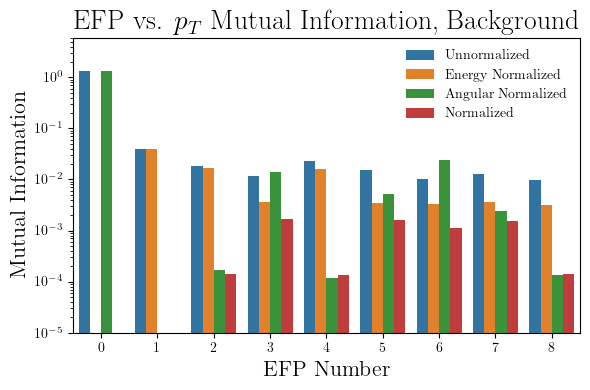

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

normalization_results_b = normalization_results_pt[normalization_results_pt.sb=='b']

hue_order = ['Unnormalized', 'Energy Normalized', 'Angular Normalized', 'Normalized']
# Create a bar plot using Seaborn with 'hue' parameter
sns.barplot(x='index', y='mi', hue='type', hue_order=hue_order, data=normalization_results_b)

# Add labels and title
plt.xlabel('EFP Number', fontsize=16)
plt.ylabel('Mutual Information', fontsize=16)
plt.title(r'EFP vs. $p_T$ Mutual Information, Background', fontsize=20)
plt.yscale('log')
plt.ylim([10e-6, 6])

# Show the plot
plt.legend(loc='upper right', frameon=False)  # Add a legend for the 'type' variable
plt.tight_layout()
plt.savefig(mutual_info_figures_path + 'efp_pt_mi_bkg.pdf')
plt.show()

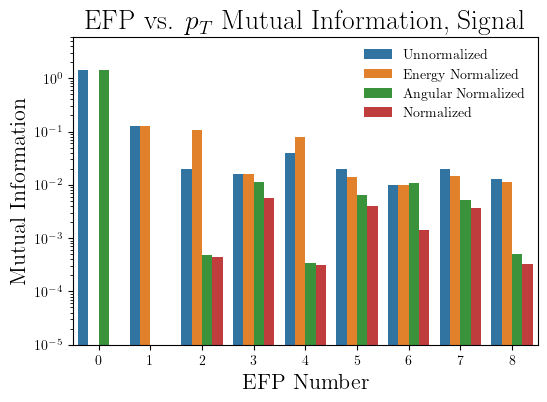

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

normalization_results_s = normalization_results_pt[normalization_results_pt.sb=='s']

hue_order = ['Unnormalized', 'Energy Normalized', 'Angular Normalized', 'Normalized']
# Create a bar plot using Seaborn with 'hue' parameter
sns.barplot(x='index', y='mi', hue='type', hue_order=hue_order, data=normalization_results_s)

# Add labels and title
plt.xlabel('EFP Number', fontsize=16)
plt.ylabel('Mutual Information', fontsize=16)
plt.title(r'EFP vs. $p_T$ Mutual Information, Signal', fontsize=20)
plt.yscale('log')
plt.ylim([10e-6, 6])


# Show the plot
plt.legend(loc='upper right', frameon=False)  # Add a legend for the 'type' variable
plt.savefig(mutual_info_figures_path + 'efp_pt_mi_sig.pdf')
plt.show()

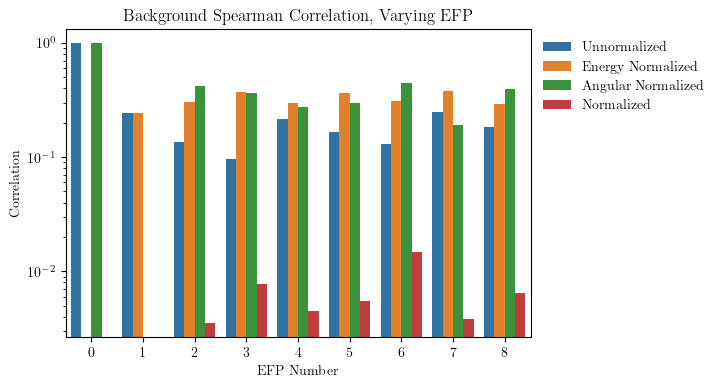

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

normalization_results_b = normalization_results_pt[normalization_results_pt.sb=='b']

hue_order = ['Unnormalized', 'Energy Normalized', 'Angular Normalized', 'Normalized']
# Create a bar plot using Seaborn with 'hue' parameter
sns.barplot(x='index', y='spearman', hue='type', hue_order=hue_order, data=normalization_results_b)

# Add labels and title
plt.xlabel('EFP Number')
plt.ylabel('Correlation')
plt.title('Background Spearman Correlation, Varying EFP')
plt.yscale('log')

# Show the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)  # Add a legend for the 'type' variable
plt.show()

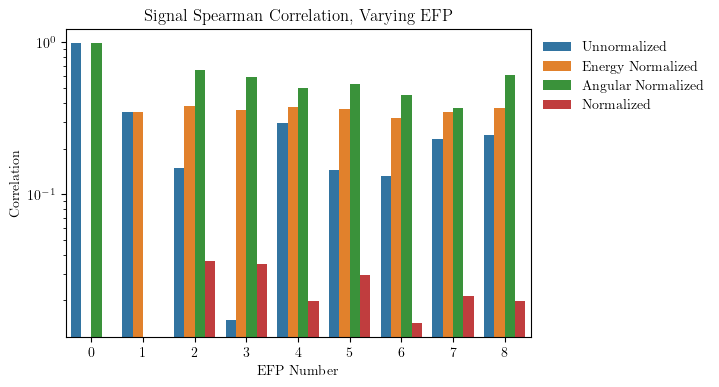

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

normalization_results_s = normalization_results_pt[normalization_results_pt.sb=='s']

hue_order = ['Unnormalized', 'Energy Normalized', 'Angular Normalized', 'Normalized']
# Create a bar plot using Seaborn with 'hue' parameter
sns.barplot(x='index', y='spearman', hue='type', hue_order=hue_order, data=normalization_results_s)

# Add labels and title
plt.xlabel('EFP Number')
plt.ylabel('Correlation')
plt.title('Signal Spearman Correlation, Varying EFP', )
plt.yscale('log')

# Show the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)  # Add a legend for the 'type' variable
plt.show()

In [12]:
normalization_results_mass = pd.DataFrame()

normalization_results_mass = pd.concat([normalization_results_mass, calculate_metrics([efps_normed_signal, efps_normed_background], [jetmasses_signal, jetmasses_background], 'Normalized')])
normalization_results_mass = pd.concat([normalization_results_mass, calculate_metrics([efps_energy_normed_signal, efps_energy_normed_background], [jetmasses_signal, jetmasses_background], 'Energy Normalized')])
normalization_results_mass = pd.concat([normalization_results_mass, calculate_metrics([efps_angle_normed_signal, efps_angle_normed_background], [jetmasses_signal, jetmasses_background], 'Angular Normalized')])
normalization_results_mass = pd.concat([normalization_results_mass, calculate_metrics([efps_signal, efps_background], [jetmasses_signal, jetmasses_background], 'Unnormalized')])

/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_ms

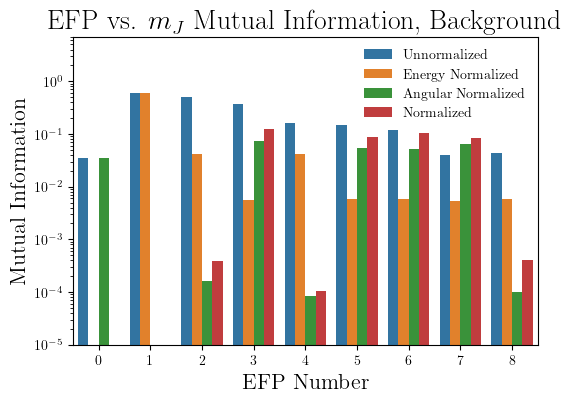

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

normalization_results_b = normalization_results_mass[normalization_results_mass.sb=='b']

hue_order = ['Unnormalized', 'Energy Normalized', 'Angular Normalized', 'Normalized']
# Create a bar plot using Seaborn with 'hue' parameter
sns.barplot(x='index', y='mi', hue='type', hue_order=hue_order, data=normalization_results_b)

# Add labels and title
plt.xlabel('EFP Number', fontsize=16)
plt.ylabel('Mutual Information', fontsize=16)
plt.title(r'EFP vs. $m_J$ Mutual Information, Background', fontsize=20)
plt.yscale('log')
plt.ylim([10e-6, 7])

# Show the plot
plt.legend(loc='upper right', frameon=False)  # Add a legend for the 'type' variable
plt.savefig(mutual_info_figures_path + 'efp_mj_mi_bkg.pdf')
plt.show()

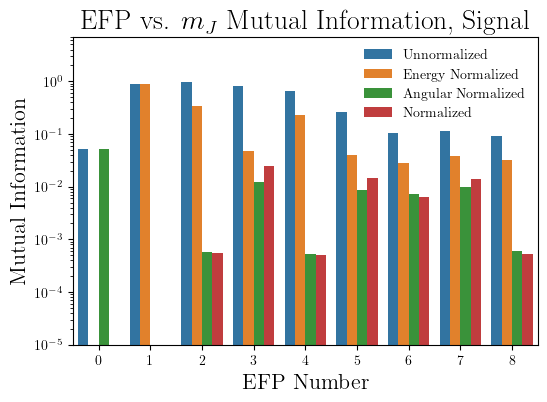

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

normalization_results_s = normalization_results_mass[normalization_results_mass.sb=='s']

hue_order = ['Unnormalized', 'Energy Normalized', 'Angular Normalized', 'Normalized']
# Create a bar plot using Seaborn with 'hue' parameter
sns.barplot(x='index', y='mi', hue='type', hue_order=hue_order, data=normalization_results_s)

# Add labels and title
plt.xlabel('EFP Number', fontsize=16)
plt.ylabel('Mutual Information', fontsize=16)
plt.title(r'EFP vs. $m_J$ Mutual Information, Signal', fontsize=20)
plt.yscale('log')
plt.ylim([10e-6, 7])

# Show the plot
plt.legend(loc='upper right', frameon=False)  # Add a legend for the 'type' variable
plt.savefig(mutual_info_figures_path + 'efp_mj_mi_sig.pdf')
plt.show()

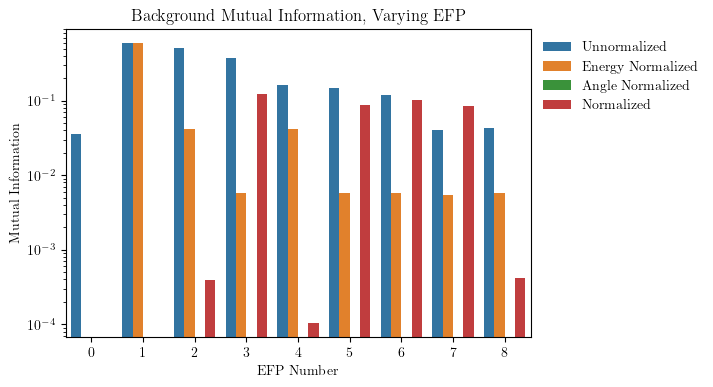

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

normalization_results_b = normalization_results_mass[normalization_results_mass.sb=='b']

hue_order = ['Unnormalized', 'Energy Normalized', 'Angle Normalized', 'Normalized']
# Create a bar plot using Seaborn with 'hue' parameter
sns.barplot(x='index', y='mi', hue='type', hue_order=hue_order, data=normalization_results_b)

# Add labels and title
plt.xlabel('EFP Number')
plt.ylabel('Mutual Information')
plt.title('Background Mutual Information, Varying EFP')
plt.yscale('log')

# Show the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)  # Add a legend for the 'type' variable
plt.show()